# Risk Premiums from Fama-Macbeth Cross-sectional Regression

- CAPM tests
- Polynomial regression, feature transformations

Copyright 2023, Terence Lim

MIT License

In [2]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import pandas_datareader as pdr
from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader
from tqdm import tqdm
from finds.database import SQL, Redis
from finds.structured import CRSP, Signals, Benchmarks
from finds.busday import BusDay
from finds.backtesting import RiskPremium
from finds.recipes import winsorize, least_squares
from finds.display import show
from conf import credentials, VERBOSE, paths, CRSP_DATE

LAST_DATE = CRSP_DATE
%matplotlib inline
VERBOSE = 0
SHOW = dict(ndigits=4, latex=None)

sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
rdb = Redis(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
signals = Signals(user)
bench = Benchmarks(sql, bd)
imgdir = paths['images']

## Retrieve market and test asset returns

In [3]:
asset_names = ['25_Portfolios_ME_BETA_5x5',
               '25_Portfolios_ME_VAR_5x5',
               '25_Portfolios_ME_RESVAR_5x5',
               '25_Portfolios_5x5']
test_assets = {asset: FamaFrenchReader(asset, start=1900, end=2099).read()
               for asset in asset_names}
#for a in test_assets.values():
#    for p in range(2):
#        a[p].index = a[p].index.strftime('%Y%m').astype(int)

mkt = FamaFrenchReader('F-F_Research_Data_Factors', start=1900, end=2099).read()
mkt = mkt[0].rename(columns={'Mkt-RF': 'BETA'})
#mkt.index = mkt.index.strftime('%Y%m').astype(int)

# Show summary statistics of Mkt-Rf, every 25 years
periods=[(1925, 2024), (1925, 1949), (1950, 1974), (1975, 1999), (2000, 2024)]
df = []
for (beg, end) in periods:
    data = mkt[(mkt.index >= f"{beg}-01") & (mkt.index <= f"{end}-12")]['BETA']
    df.append(DataFrame({'of months': len(data),
                         'annual mean': 12*np.mean(data),
                         'annual stdev': np.std(data)*np.sqrt(12),
                         'sharpe ratio': np.mean(data)*np.sqrt(12)/np.std(data),
                         'skewness': skew(data),
                         'excess kurtosis': kurtosis(data, fisher=True)},
                        index=[f"{str(data.index[0])[:4]}-" + 
                               f"{str(data.index[-1])[:4]}"]))
show(pd.concat(df),
     caption="Summary statistics of Mkt-RF monthly returns", **SHOW)

,of months,annual mean,annual stdev,sharpe ratio,skewness,excess kurtosis
Summary statistics of Mkt-RF monthly returns,,,,,,
1926-2022,1157,8.0864,18.5308,0.4364,0.1589,7.4245
1926-1949,282,8.6630,26.6461,0.3251,0.4932,5.5027
1950-1974,300,6.4956,13.5968,0.4777,-0.2875,0.8862
1975-1999,300,10.7464,15.3718,0.6991,-0.7028,3.2154
2000-2022,275,6.3286,16.0013,0.3955,-0.4957,0.7780


## Fama-MacBeth regressions with 5x5 test assets and estimated loadings

In [23]:
periods = [mkt.index[0], '1963-07']
out = {period: [] for period in periods}
for period in periods:
    
    for asset in asset_names:
        by_asset = []
    
        for p, wt in enumerate(['Value-weighted', 'Equal-weighted']):
            # subtract riskfree, and stack data as thin dataframe
            f = test_assets[asset][p]
            df = f.sub(mkt['RF'], axis=0).dropna().copy()
            rets = df.stack().reset_index(name='ret')\
                             .rename(columns={'level_1':'port',
                                              'level_0':'Date'})
            data = df.join(mkt[['BETA']], how='left')
            data = data[data.index >= period]

            # estimate test assets market betas from time-series of returns
            betas = least_squares(data,
                                  y=df.columns,
                                  x=['BETA'],
                                  stdres=True)[['BETA', 'stdres']]  
        
            # orthogonalize beta^2 and residual-volatility regressors
            betas['RES'] = smf.ols("stdres ~ BETA", data=betas).fit().resid
            betas['BETA2'] = smf.ols("I(BETA**2) ~ BETA + RES",
                                     data=betas).fit().resid
            r = rets.join(betas, on='port')\
                    .sort_values(['port', 'Date'], ignore_index=True)
        
            # run monthly Fama MacBeth cross-sectional regressions
            fm = r.groupby(by='Date').apply(least_squares,
                                            y=['ret'],
                                            x=['BETA', 'BETA2', 'RES'])

            # time-series means and standard errors of the FM coefficients
            sub = DataFrame({'mean': fm.mean(),
                             'stderr': fm.sem(),
                             'tstat': fm.mean() / fm.sem()}).T
            sub.columns = pd.MultiIndex.from_tuples([(wt, col)
                                                     for col in sub.columns])
            sub.index = pd.MultiIndex.from_tuples([(asset, row)
                                                   for row in sub.index])
            by_asset.append(sub)
        out[period].append(pd.concat(by_asset, axis=1))
p = periods[0]
show(pd.concat(out[p]),
     caption=[None, f"Fama-Macbeth Monthly Cross-sectional Regressions"
                    + f" {p} to {df.index[-1]}"], **SHOW)

Value-weighted  \
                                                                                    Intercept   
                            Fama-Macbeth Monthly Cross-sectional Regression...                  
25_Portfolios_ME_BETA_5x5   mean                                                       0.7034   
                            stderr                                                     0.1644   
                            tstat                                                      4.2781   
25_Portfolios_ME_VAR_5x5    mean                                                       1.1569   
                            stderr                                                     0.1957   
                            tstat                                                      5.9118   
25_Portfolios_ME_RESVAR_5x5 mean                                                       1.2813   
                            stderr                                                     0.2130   
                            tstat                                                      6.0165   
25_Portfolios_5x5           mean                                                       0.3702   
                            stderr                                                     0.3241   
                            tstat                                                      1.1422   

                                                                                        \
                                                                                  BETA   
                            Fama-Macbeth Monthly Cross-sectional Regression...           
25_Portfolios_ME_BETA_5x5   mean                                                0.0486   
                            stderr                                              0.2388   
                            tstat                                               0.2036   
25_Portfolios_ME_VAR_5x5    mean                                               -0.3828   
                            stderr                                              0.2595   
                            tstat                                              -1.4750   
25_Portfolios_ME_RESVAR_5x5 mean                                               -0.4951   
                            stderr                                              0.2721   
                            tstat                                              -1.8192   
25_Portfolios_5x5           mean                                                0.4295   
                            stderr                                              0.3510   
                            tstat                                               1.2236   

                                                                                        \
                                                                                 BETA2   
                            Fama-Macbeth Monthly Cross-sectional Regression...           
25_Portfolios_ME_BETA_5x5   mean                                               -1.1835   
                            stderr                                              0.3568   
                            tstat                                              -3.3169   
25_Portfolios_ME_VAR_5x5    mean                                               -1.9190   
                            stderr                                              0.3601   
                            tstat                                              -5.3296   
25_Portfolios_ME_RESVAR_5x5 mean                                               -2.6932   
                            stderr                                              0.4310   
                            tstat                                              -6.2492   
25_Portfolios_5x5           mean                                               -3.0430   
                            stderr                                              1.0274   
            

### Post-1963 time-period

In [25]:
p = periods[1]
show(pd.concat(out[p]),
     caption=[None, f"Fama-Macbeth Monthly Cross-sectional Regressions"
                    + f" {p} to {df.index[-1]}"], **SHOW)

Value-weighted  \
                                                                                    Intercept   
                            Fama-Macbeth Monthly Cross-sectional Regression...                  
25_Portfolios_ME_BETA_5x5   mean                                                       0.7034   
                            stderr                                                     0.1644   
                            tstat                                                      4.2781   
25_Portfolios_ME_VAR_5x5    mean                                                       1.1569   
                            stderr                                                     0.1957   
                            tstat                                                      5.9118   
25_Portfolios_ME_RESVAR_5x5 mean                                                       1.2813   
                            stderr                                                     0.2130   
                            tstat                                                      6.0165   
25_Portfolios_5x5           mean                                                       1.2259   
                            stderr                                                     0.3236   
                            tstat                                                      3.7884   

                                                                                        \
                                                                                  BETA   
                            Fama-Macbeth Monthly Cross-sectional Regression...           
25_Portfolios_ME_BETA_5x5   mean                                                0.0486   
                            stderr                                              0.2388   
                            tstat                                               0.2036   
25_Portfolios_ME_VAR_5x5    mean                                               -0.3828   
                            stderr                                              0.2595   
                            tstat                                              -1.4750   
25_Portfolios_ME_RESVAR_5x5 mean                                               -0.4951   
                            stderr                                              0.2721   
                            tstat                                              -1.8192   
25_Portfolios_5x5           mean                                               -0.3066   
                            stderr                                              0.3368   
                            tstat                                              -0.9102   

                                                                                        \
                                                                                 BETA2   
                            Fama-Macbeth Monthly Cross-sectional Regression...           
25_Portfolios_ME_BETA_5x5   mean                                               -1.1835   
                            stderr                                              0.3568   
                            tstat                                              -3.3169   
25_Portfolios_ME_VAR_5x5    mean                                               -1.9190   
                            stderr                                              0.3601   
                            tstat                                              -5.3296   
25_Portfolios_ME_RESVAR_5x5 mean                                               -2.6932   
                            stderr                                              0.4310   
                            tstat                                              -6.2492   
25_Portfolios_5x5           mean                                               -5.8519   
                            stderr                                              1.1815   
            

### Compare to robust cov

In [26]:
ls = smf.ols("ret ~ BETA + BETA2 + RES", data=r).fit()
print(ls.summary())
print(ls.get_robustcov_results('HC0').summary())
print(ls.get_robustcov_results('HAC', maxlags=6).summary())
print(ls.get_robustcov_results('hac-panel',
                               groups=r['port'],
                               maxlags=6).summary())
print(ls.get_robustcov_results('cluster', groups=r['port']).summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.383
Date:                Tue, 10 Jan 2023   Prob (F-statistic):           0.000255
Time:                        16:37:14   Log-Likelihood:            -1.0116e+05
No. Observations:               28925   AIC:                         2.023e+05
Df Residuals:                   28921   BIC:                         2.024e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6698      0.403      4.146      0.0

## Fama-MacBeth with individual stock returns and standardized scores
Stock exposures: winsored at 5% tail
- size: -log of market cap, standardized
- hml: book-to-market ratio, standardized 
- mom: 12-month skip past month momentum, standardized
- beta: regression of 3 year's weekly returns (min 1 year), shunk by 1/3 to 1.

In [30]:
rebalbeg=19640601
rebalend=LAST_DATE
rebaldates = crsp.bd.date_range(rebalbeg, rebalend, 'endmo')
loadings = dict()
for pordate in tqdm(rebaldates):           # retrieve signal values every month
    date = bd.june_universe(pordate)
    univ = crsp.get_universe(date)
    cap = np.sqrt(crsp.get_cap(date))
    smb = -np.log(cap).rename('size')
    hml = signals('hml', date, bd.endmo(date, -12))['hml'].rename('value')
    beta = signals('beta', pordate, bd.begmo(pordate))['beta']*2/3 + 1/3 #shrink
    mom = signals('mom', pordate)['mom'].rename('momentum')
    df = pd.concat((beta, hml, smb, mom),  # inner join of signals with univ
                   join='inner',
                   axis=1).reindex(univ.index).dropna()
    loadings[pordate] = winsorize(df, quantiles=[0.05, 0.95])

100%|█████████████████████████████████████████| 694/694 [08:10<00:00,  1.41it/s]


In [31]:
# Compute coefficients from FM cross-sectional regressions
riskpremium = RiskPremium(user, bench, 'RF', LAST_DATE)
riskpremium(stocks=crsp,        # FM regressions on standardized scores
            loadings=loadings,
            standardize=['value' ,'size', 'momentum'])

,mean,stderr,std,count
beta,0.007722,0.002091,0.055049,693
value,0.002238,0.000389,0.010249,693
size,0.002253,0.000685,0.018037,693
momentum,0.001955,0.000578,0.015213,693


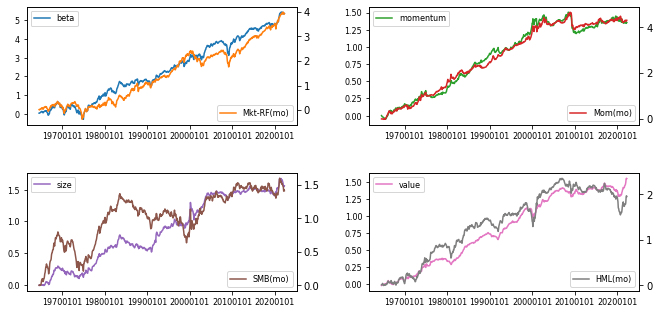

In [32]:
# Compare estimated risk premiums to benchmark factors
benchnames = {'beta': 'Mkt-RF(mo)',
              'momentum': 'Mom(mo)',
              'size':'SMB(mo)',
              'value': 'HML(mo)'}
out = riskpremium.fit(benchnames.values())  # to compare portfolio-sorts
riskpremium.plot(benchnames)
plt.savefig(imgdir / 'fm.jpg')

### Summarize time-series means of Fama-Macbeth risk premiums

In [33]:
caption, df = ["Fama-MacBeth Cross-sectional Regression Risk Premiums", out[0]]
df['tvalue'] = df['mean']/df['stderr']
df['sharpe'] = np.sqrt(12) * df['mean']/df['std']
show(df, caption=caption, **SHOW)

Factor Returns,mean,stderr,std,count,tvalue,sharpe
Fama-MacBeth Cross-sectional Regression Risk Premiums,,,,,,
beta,0.0077,0.0021,0.0550,693,3.6925,0.4859
value,0.0022,0.0004,0.0102,693,5.7491,0.7565
size,0.0023,0.0007,0.0180,693,3.2874,0.4326
momentum,0.0020,0.0006,0.0152,693,3.3831,0.4452


### Summarize time-series means of Fama-French portfolio sort returns

In [34]:
caption, df = ["Fama-French Portfolio-Sorts", out[2]]
df['tvalue'] = df['mean']/df['stderr']
df['sharpe'] = np.sqrt(12) * df['mean']/df['std']
show(df, caption=caption, **SHOW)

Benchmarks,mean,stderr,std,count,tvalue,sharpe
Fama-French Portfolio-Sorts,,,,,,
Mkt-RF(mo),0.0057,0.0017,0.0448,693,3.3363,0.4390
Mom(mo),0.0062,0.0016,0.0423,693,3.8607,0.5080
SMB(mo),0.0020,0.0012,0.0308,693,1.7436,0.2294
HML(mo),0.0028,0.0011,0.0296,693,2.5013,0.3291


## Show correlation of returns

In [35]:
df = pd.concat([out[1].join(out[4]), out[4].T.join(out[3])], axis=0)
show(df, caption='Correlation of Fama-MacBeth Risk Premiums'
     + ' and Fama-French Portfolio-Sort Returns', **SHOW)

,beta,value,size,momentum,Mkt-RF(mo),Mom(mo),SMB(mo),HML(mo)
Correlation of Fama-MacBeth Risk Premiums and Fama-French Portfolio-Sort Returns,,,,,,,,
beta,1.0000,-0.0002,0.3175,-0.2476,0.8707,-0.2841,0.6401,-0.1132
value,-0.0002,1.0000,-0.1713,-0.2800,-0.0578,-0.2454,-0.1528,0.7920
size,0.3175,-0.1713,1.0000,-0.0945,-0.0444,0.1073,0.5937,-0.1369
momentum,-0.2476,-0.2800,-0.0945,1.0000,-0.0630,0.8406,-0.0138,-0.2631
Mkt-RF(mo),0.8707,-0.0578,-0.0444,-0.0630,1.0000,-0.1591,0.2993,-0.2198
Mom(mo),-0.2841,-0.2454,0.1073,0.8406,-0.1591,1.0000,-0.0267,-0.2190
SMB(mo),0.6401,-0.1528,0.5937,-0.0138,0.2993,-0.0267,1.0000,-0.1701
HML(mo),-0.1132,0.7920,-0.1369,-0.2631,-0.2198,-0.2190,-0.1701,1.0000
